In [23]:
import os
os.chdir('../')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style='white')

from scipy.stats import pearsonr, spearmanr, zscore
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

### Annotations

- df: contains results for train and val video splits (use this to train and validate the bias-predictor)
- test: results for test split, use this only to see the final results

In [2]:
data = pd.read_csv('inference.csv')
data['error'] = data['true_ef'] - data['predicted_ef']

df = data[(data['split'] == 'TRAIN') | (data['split'] == 'VAL')]
test = data[ data['split'] == 'TEST' ]

### Resnet50-UNet Segmentation and Heuristic estimation of EF

In [3]:
predictions = test['predicted_ef']
true_values = test['true_ef']

mean_absolute_error(true_values, predictions)

6.429275796053563

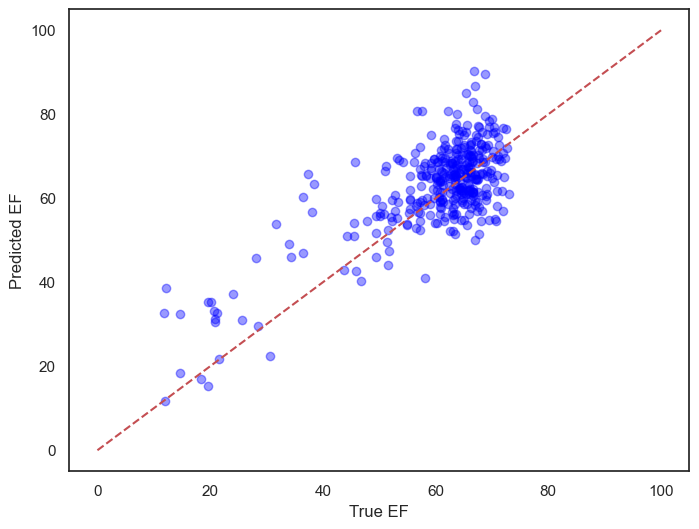

In [4]:
plt.figure(figsize=(8, 6))
plt.scatter(test['true_ef'], test['predicted_ef'], alpha=0.4, color='blue')
plt.plot([0, 100], [0, 100], 'r--')
plt.xlabel("True EF")
plt.ylabel("Predicted EF")
plt.show()

### Bias Predictor

- The idea is to build a machine learning model that predicts the signed error between the true and (heuristic) predicted ejection fraction
- Take as input geometric features from frame-by-frame segmentation

### Signed Error Distribution

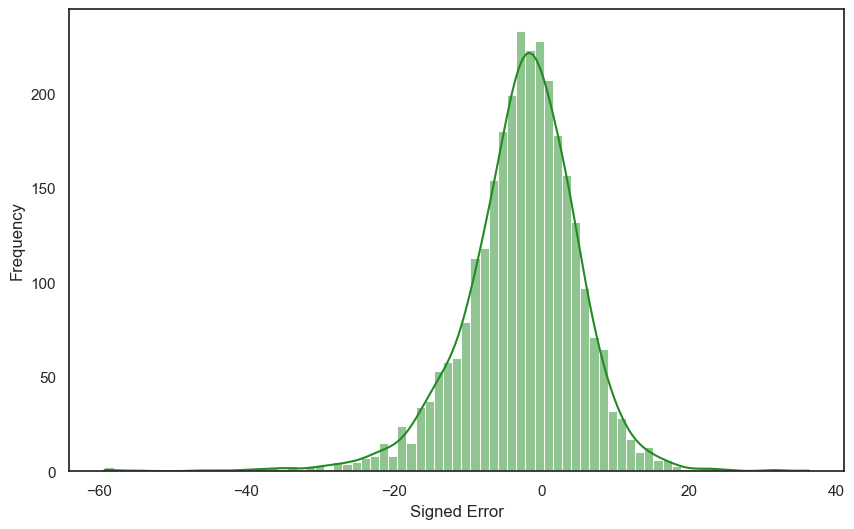

In [5]:
plt.figure(figsize=(10,6))
sns.histplot(df['error'], color='forestgreen', kde=True)
plt.ylabel('Frequency')
plt.xlabel('Signed Error')
plt.show()

In [6]:
df.describe()

,true_ef,predicted_ef,volume_ratio,length_ratio,error
count,2913.000000,2913.000000,2913.000000,2913.000000,2913.000000
mean,61.038084,63.614925,0.363851,0.721772,-2.576840
std,10.385483,9.812477,0.098125,0.066943,7.921652
min,7.020000,9.483829,0.000104,0.039866,-59.229980
25%,59.650000,59.908336,0.308863,0.688202,-6.675086
50%,63.470000,64.825520,0.351745,0.722945,-1.979077
75%,67.010000,69.113681,0.400917,0.755733,2.284445
max,72.970000,99.989601,0.905162,0.960815,36.321115


### Z-score outliers deletion

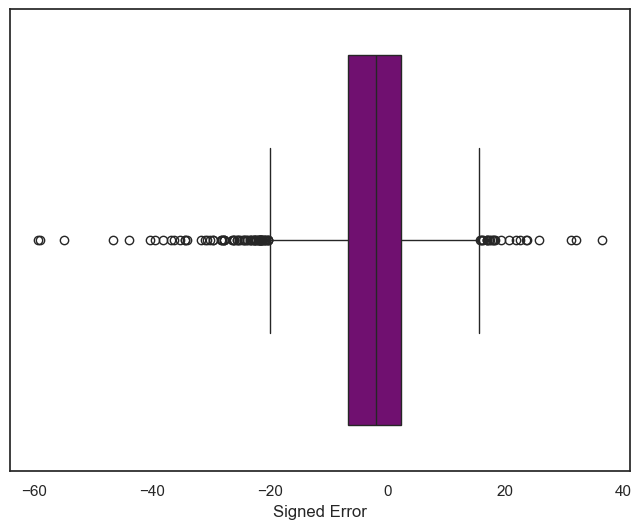

In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(x=df['error'], color='purple')
plt.xlabel('Signed Error')
plt.show()

In [8]:
z = np.abs(zscore(df['error']))
filtered_df = df[(z < 2)]

print('original data shape: ', df.shape)
print('no-outliers data shape: ', filtered_df.shape)

original data shape:  (2913, 7)
no-outliers data shape:  (2783, 7)


In [9]:
df = filtered_df

In [10]:
df.drop(columns=['filename', 'split', 'true_ef', 'predicted_ef'], inplace=True)

In [11]:
X, y = df.drop('error', axis=1), df['error']

In [12]:
df.columns

Index(['volume_ratio', 'length_ratio', 'error'], dtype='object')

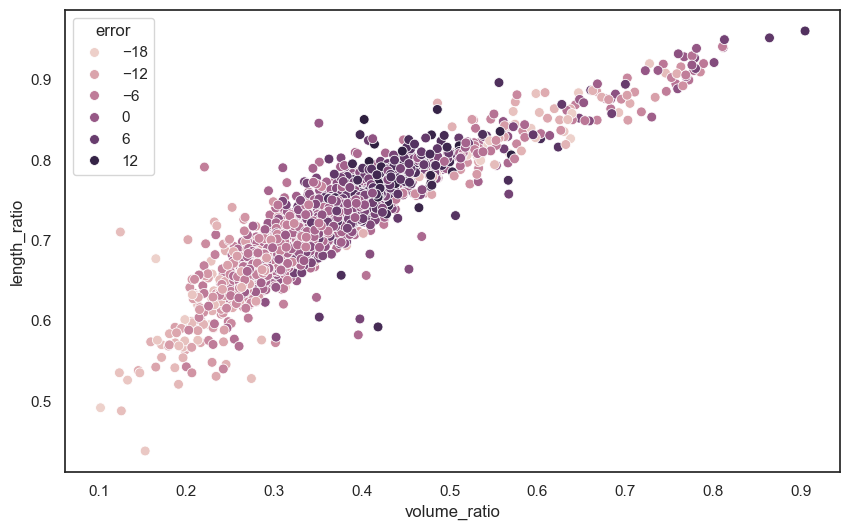

In [13]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='volume_ratio', y='length_ratio', data=X, hue=y, s=50)
plt.show()

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

models = [
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=1)),
    ('Gradient Boosting', GradientBoostingRegressor(n_estimators=100, random_state=1)),
    ('K-Nearest Neighbors', KNeighborsRegressor())
]

In [15]:
results = []

for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae_value = mean_absolute_error(y_test, y_pred)
    mse_value = mean_squared_error(y_test, y_pred)
    r2_value = r2_score(y_test, y_pred)

    results.append({
        'Model': name,
        'MAE': mae_value,
        'MSE': mse_value,
        'R^2': r2_value
    })

results_df = pd.DataFrame(results)
results_df.sort_values(by='R^2', ascending=False, inplace=True)
results_df

,Model,MAE,MSE,R^2
1,Gradient Boosting,4.231178,29.363529,0.266466
2,K-Nearest Neighbors,4.431786,31.017005,0.225161
0,Random Forest,4.493851,33.064356,0.174016


In [28]:
reg = GradientBoostingRegressor()

param_grid = {
    'random_state': [1],
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 8],
    'max_features': ['sqrt', 'log2', None]
}

grid = GridSearchCV(
    estimator=reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid.fit(X, y)

Fitting 5 folds for each of 120 candidates, totalling 600 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.2],
                         'max_depth': [3, 4, 5, 6, 8],
                         'max_features': ['sqrt', 'log2', None],
                         'n_estimators': [100, 200], 'random_state': [1]},
             scoring='neg_mean_squared_error', verbose=1)

In [34]:
X_test = test[['volume_ratio', 'length_ratio']]
y_test = test['error']

In [36]:
reg = grid.best_estimator_
y_pred = reg.predict(X_test)

mae_value = mean_absolute_error(y_test, y_pred)
mse_value = mean_squared_error(y_test, y_pred)
r2_value = r2_score(y_test, y_pred)

print('MAE:', mae_value)
print('MSE:', mse_value)
print('R^2:', r2_value)

MAE: 4.730154785763453
MSE: 41.144731522764744
R^2: 0.34838936655246566


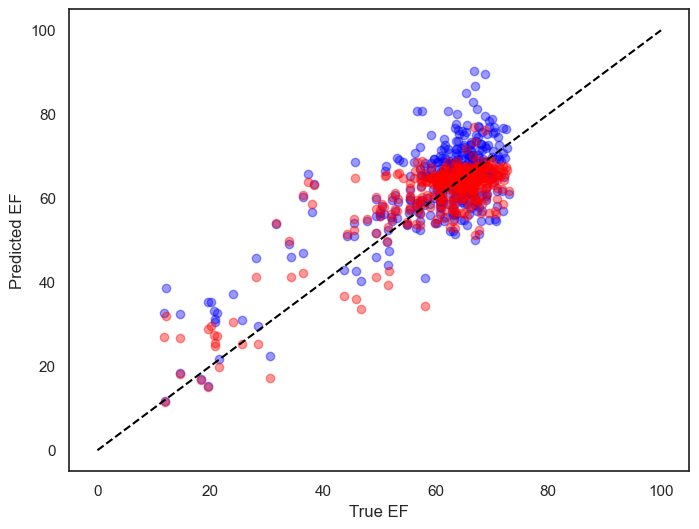

In [37]:
plt.figure(figsize=(8, 6))
plt.plot([0, 100], [0, 100], '--', color='black')
plt.scatter(true_values, predictions, alpha=0.4, color='blue')
plt.scatter(true_values, predictions + y_pred, alpha=0.4, color='red')
plt.xlabel("True EF")
plt.ylabel("Predicted EF")
plt.show()

In [38]:
print('Original MAE: ', mean_absolute_error(true_values, predictions))
print('New MAE: ', mean_absolute_error(true_values, predictions + y_pred))

Original MAE:  6.429275796053563
New MAE:  4.730154785763453
